# Causal Inference: The Mixtape Book Club
With included code from Statistical Rethinking

In [1]:
import daft
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm 
import statsmodels.formula.api as smf

## List of DAG components

### Direct effect

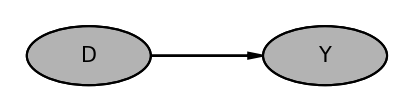

In [2]:
pgm = daft.PGM(aspect=2.1, dpi=150)
pgm.add_node("D","D", 3.0, 3.0,  observed=True)
pgm.add_node("Y","Y",  5.0, 3.0, observed=True)
pgm.add_edge("D", "Y")
pgm.render();

### Mediated effect

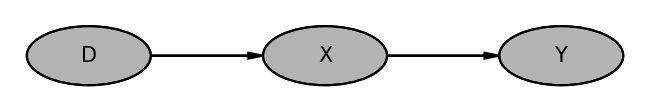

In [3]:
pgm = daft.PGM(aspect=2.1, dpi=150)
pgm.add_node("D","D", 3.0, 3.0, observed=True)
pgm.add_node("X","X",  5.0, 3.0, observed=True)
pgm.add_node("Y","Y",  7.0, 3.0, observed=True)
pgm.add_edge("D", "X")
pgm.add_edge("X", "Y")

pgm.render();

### Confounder
To close a backdoor path always condition on the cofounder

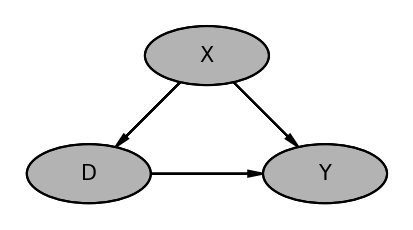

In [4]:
pgm = daft.PGM(aspect=2.1, dpi=150)
pgm.add_node("D","D", 0, 0, observed=True)
pgm.add_node("X","X",  1, 1, observed=True)
pgm.add_node("Y","Y",  2, 0, observed=True)
pgm.add_edge("D", "Y")
pgm.add_edge("X", "D")
pgm.add_edge("X", "Y")


pgm.render();

In [5]:
def confounder(size):
    """Create a confounder example"""
    
    # Is confounder additive or multiplicative
    np.random.seed(100)
    unit_normal = stats.norm(0,1)
    x = unit_normal.rvs(size)
    d = (unit_normal.rvs(size))
    
    # For some reason need to add the coefficient here
    y = 3.56*d + 6.789*x + 21.123
    
    cofounder_df = pd.DataFrame({"x":x, "d":d, "y":y})
    return cofounder_df

confounder_df = confounder(1000)
mod = smf.ols(formula='y ~ d+x', data=confounder_df)
res = mod.fit()
res.params

Intercept    21.123
d             3.560
x             6.789
dtype: float64

#### Without conditioning on confounder

In [6]:
mod = smf.ols(formula='y ~ d', data=confounder_df)
res = mod.fit()
res.params

Intercept    21.009423
d             3.527294
dtype: float64

#### With conditioning on confounder

In [7]:
mod = smf.ols(formula='y ~ d+x', data=confounder_df)
res = mod.fit()
res.params

Intercept    21.123
d             3.560
x             6.789
dtype: float64

### Collider

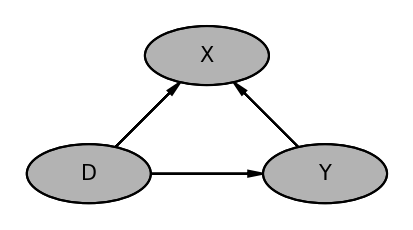

In [8]:
pgm = daft.PGM(aspect=2.1, dpi=150)
pgm.add_node("D","D", 0, 0, observed=True)
pgm.add_node("X","X",  1, 1, observed=True)
pgm.add_node("Y","Y",  2, 0, observed=True)
pgm.add_edge("D", "Y")
pgm.add_edge("D", "X")
pgm.add_edge("Y", "X")


pgm.render();

In [9]:
def collider(size):
    """Create a collider example"""
    
    # Is confounder additive or multiplicative
    unit_normal = stats.norm(0,1)
    d = unit_normal.rvs(size) 
    
    # For some reason need to add the coefficient here
    y = 3.567*d  + 21.123
    
    # Collider
    x = 3.567*d + y
    
    collider_df = pd.DataFrame({"x":x, "d":d, "y":y})
    return collider_df

collider_df = collider(1000)

#### Without conditioning on collider
Coefficient is correct

In [10]:
mod = smf.ols(formula='y ~ d', data=collider_df)
res = mod.fit()
res.params

Intercept    21.123
d             3.567
dtype: float64

#### With conditioning on collider
Causes issues

In [11]:
mod = smf.ols(formula='y ~ d+x', data=collider_df)
res = mod.fit()
res.params

Intercept    1.121597
d           -3.188196
x            0.946902
dtype: float64

### Collider example; Happiness mistakenly negatively correlated with age
This one is from Rethinking, in particular highlighting that the third edge is not needed for there to be a coilider.

#### Explanation
We are interested in the effective of age on happiness. IF we condition on marriage however what happens is the regression shows happiness and age are negatively correlated. However this is because if we include marriage in the regression what happens is the happiest people get married as time progresses
* Unhappy people are less likely to get married
* Age and marriage is correlated with happiness
  * We can use both to estimate how happy someone is
  * Age has no causal effect on happiness
* Predictive power and causality is not the same

* The way the data is generated and the way I write the model is not guaranteed to match at all


TLDR
* If you're trying to predict happiness use marriage and age
* If you're trying to understand if happiness marriage is bad

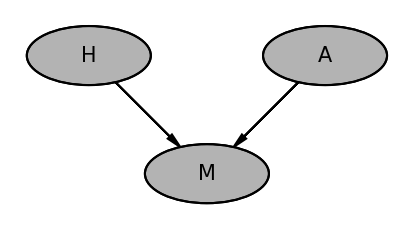

In [12]:
pgm = daft.PGM(aspect=2.1, dpi=150)
pgm.add_node("H","H", 0, 0, observed=True)
pgm.add_node("M","M",  1, -1, observed=True)
pgm.add_node("A","A",  2, 0, observed=True)
pgm.add_edge("H", "M")
pgm.add_edge("A", "M")


pgm.render();

In [14]:
def collider(size):
    """Create a collider example"""
    
    # Is confounder additive or multiplicative
    unit_normal = stats.norm(0,1)
    H = unit_normal.rvs(size) 
    A = unit_normal.rvs(size) 

    M = 1.23*H + 4.56*A

    collider_df = pd.DataFrame({"H":H, "A":A, "M":M})
    return collider_df

collider_df = collider(1000)

### The correct regression

In [15]:
mod = smf.ols(formula='H ~ A', data=collider_df)
res = mod.fit()
res.params

Intercept   -0.047381
A           -0.021285
dtype: float64

In [16]:
mod = smf.ols(formula='H ~ M+A', data=collider_df)
res = mod.fit()
res.params

Intercept   -1.734723e-16
M            8.130081e-01
A           -3.707317e+00
dtype: float64

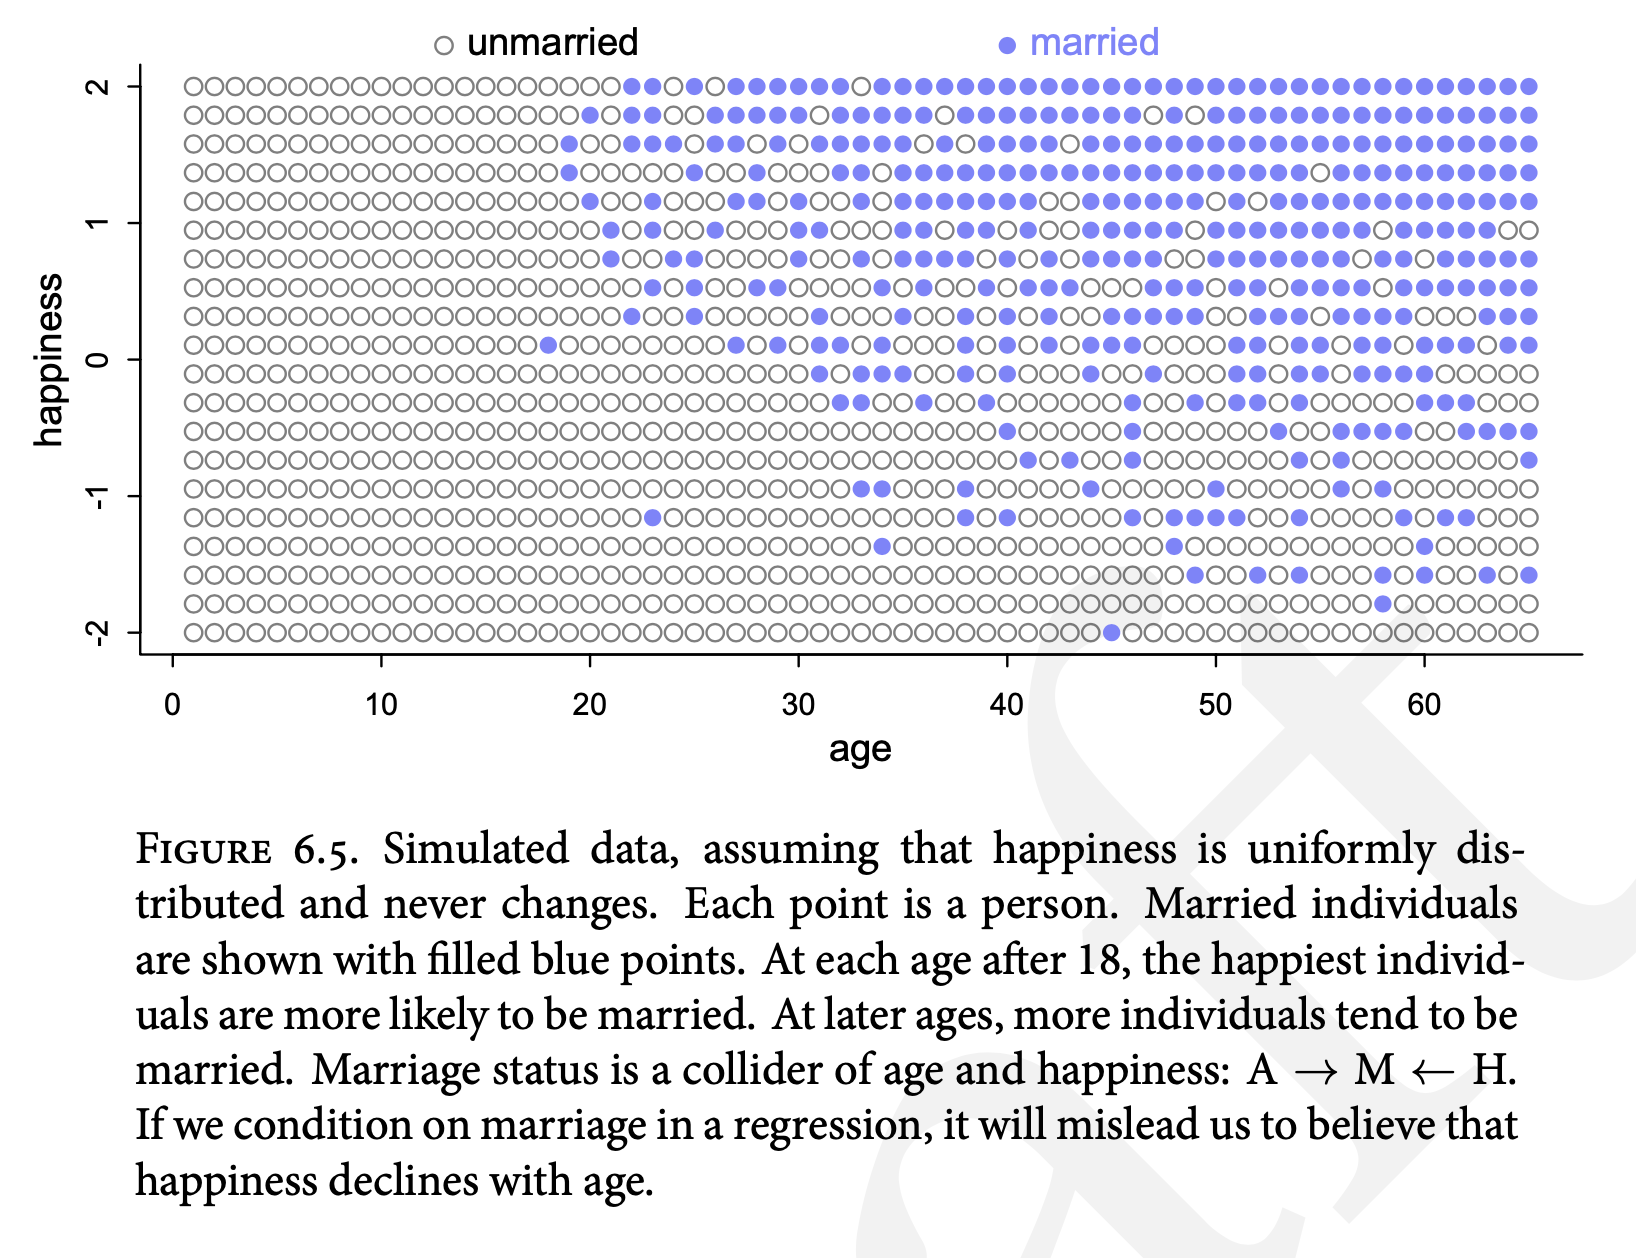

### Collider and Confounder



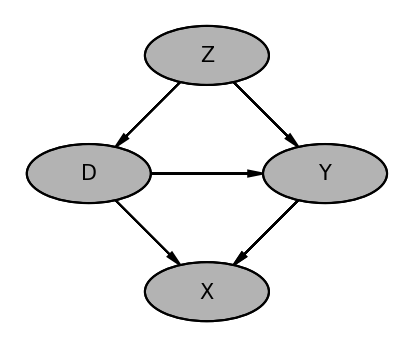

In [17]:
pgm = daft.PGM(aspect=2.1, dpi=150)

pgm.add_node("Z","Z", 1, 1, observed=True)
pgm.add_node("D","D", 0, 0, observed=True)
pgm.add_node("X","X",  1, -1, observed=True)
pgm.add_node("Y","Y",  2, 0, observed=True)

# Confounder
pgm.add_edge("Z", "D")
pgm.add_edge("Z", "Y")
pgm.add_edge("Y", "X")

# Collider
pgm.add_edge("D", "Y")
pgm.add_edge("D", "X")
pgm.add_edge("Y", "X")


pgm.render();

In [18]:
def collider_and_confounder(size):
    """Create a collider and confounder example"""
    
    # Is confounder additive or multiplicative
    unit_normal = stats.norm(0,1)
    d = unit_normal.rvs(size) 
    z = unit_normal.rvs(size) 
    # For some reason need to add the coefficient here
    y = 3.567*d + 1.234*z + 21.123
    
    x = 8.9*d + y
    
    collider_and_confounder_df = pd.DataFrame({"x":x, "d":d, "z":z, "y":y})
    return collider_and_confounder_df

collider_and_confounder_df = collider_and_confounder(1000)

In [19]:
mod = smf.ols(formula='y ~ d+z', data=collider_and_confounder_df)
res = mod.fit()
res.params

Intercept    21.123
d             3.567
z             1.234
dtype: float64